In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask, select_with_masks
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object


In [6]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-coded rejection flags found in output files

# logger/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim/retis.rst
logger = logging.getLogger(__name__)

def get_transition_probs(pes, interfaces, weights = None, tr=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

        # if tr:  # TR reweighting. Note this is not block-friendly TODO
        #     w_path[i]['RMR'] *= 2
        #     w_path[i]['LML'] *= 2
        #     temp = w_path[i]['RML'] + w_path[i]['LMR']
        #     w_path[i]['RML'] = temp
        #     w_path[i]['LMR'] = temp

    p = np.empty([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i == k:
                if i == 0:
                    p[i][k] = np.sum(w_path[i+1]["ends"][i][k]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                else:
                    p[i][k] = 0
            elif i < k:
                p_reachedj = np.empty(k-i+1)
                p_jtillend = np.empty(k-i+1)
                w_reachedj = np.empty(k-i+1)
                w_jtillend = np.empty(k-i+1)
                for j in range(i, k+1):
                    p_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][j:]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                    w_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][i:])
                    if j < len(interfaces)-1:
                        p_jtillend[j-i] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][i:]) if np.sum(w_path[j+1]["ends"][i][i:]) != 0 else 0
                        w_jtillend[j-i] = np.sum(w_path[j+1]["ends"][i][i:])
                    else: 
                        p_jtillend[j-i] = 1
                        w_jtillend[j-i] = 1
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0                
                # p[i][k] = np.average(p_reachedj * p_jtillend)
            elif i > k:
                p_reachedj = np.empty(i-k+1)
                p_jtillend = np.empty(i-k+1)
                w_reachedj = np.empty(i-k+1)
                w_jtillend = np.empty(i-k+1)
                for j in range(k, i+1):
                    if i < len(interfaces)-1:
                        p_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:j+1]) / np.sum(w_path[i+1]["ends"][i][:i+1]) if np.sum(w_path[i+1]["ends"][i][:i+1]) != 0 else 0
                        p_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][:i+1]) if np.sum(w_path[j+1]["ends"][i][:i+1]) != 0 else 0
                        w_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:i+1])
                        w_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][:i+1])
                    else: 
                        p_reachedj[j-k] = 0
                        p_jtillend[j-k] = 0
                        w_reachedj[j-k] = 0
                        w_jtillend[j-k] = 0
                    
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0
                # p[i][k] = np.average(p_reachedj * p_jtillend)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [7]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-coded rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_transition_probz(pes, interfaces, weights = None, tr=False): # cut memory
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

        # if tr:  # TR reweighting. Note this is not block-friendly TODO
        #     w_path[i]['RMR'] *= 2
        #     w_path[i]['LML'] *= 2
        #     temp = w_path[i]['RML'] + w_path[i]['LMR']
        #     w_path[i]['RML'] = temp
        #     w_path[i]['LMR'] = temp

    p = np.empty([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i == k:
                if i == 0:
                    p[i][k] = np.sum(w_path[i+1]["ends"][i][k]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                else:
                    p[i][k] = 0
            elif i < k:
                p_reachedj = np.empty(k-i+1)
                p_jtillend = np.empty(k-i+1)
                w_reachedj = np.empty(k-i+1)
                w_jtillend = np.empty(k-i+1)
                for j in range(i, k+1):
                    p_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][j:]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                    w_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][i:])
                    if j < len(interfaces)-1:
                        p_jtillend[j-i] = np.sum(w_path[j+1]["ends"][:k, k]) / np.sum(np.triu(w_path[j+1]["ends"])[:k]) if np.sum(np.triu(w_path[j+1]["ends"])[:k]) != 0 else 0
                        w_jtillend[j-i] = np.sum(np.triu(w_path[j+1]["ends"])[:k])
                    else: 
                        p_jtillend[j-i] = 1
                        w_jtillend[j-i] = 1
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0                
                # p[i][k] = np.average(p_reachedj * p_jtillend)
            elif i > k:
                p_reachedj = np.empty(i-k+1)
                p_jtillend = np.empty(i-k+1)
                w_reachedj = np.empty(i-k+1)
                w_jtillend = np.empty(i-k+1)
                for j in range(k, i+1):
                    if i < len(interfaces)-1:
                        p_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:j+1]) / np.sum(w_path[i+1]["ends"][i][:i+1]) if np.sum(w_path[i+1]["ends"][i][:i+1]) != 0 else 0
                        p_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(np.tril(w_path[j+1]["ends"])[k:]) if np.sum(np.tril(w_path[j+1]["ends"])[k:]) != 0 else 0
                        w_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:i+1])
                        w_jtillend[j-k] = np.sum(np.tril(w_path[j+1]["ends"])[k:])
                    else: 
                        p_reachedj[j-k] = 0
                        p_jtillend[j-k] = 0
                        w_reachedj[j-k] = 0
                        w_jtillend[j-k] = 0
                    
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0
                # p[i][k] = np.average(p_reachedj * p_jtillend)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [119]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-coded rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_transition_probzz(pes, interfaces, weights = None, tr=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    if i in {1,2} and j == 0 and k == 1:
                        dir_mask = pe.dirs < 2
                    else:
                        dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    if i in {1,2} and j == 1 and k == 0:
                        dir_mask = pe.dirs > 2
                    else:
                        dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

    p = np.empty([len(interfaces), len(interfaces)])
    q = np.ones([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            counts = np.zeros(2)
            if i == k:
                if i == 0:
                    counts += [np.sum(w_path[i+1]["ends"][i][k]), np.sum(w_path[i+1]["ends"][i][k])]
                else:
                    q[i][k] = 0
                    continue
            elif i == 0 and k == 1:
                q[i][k] = (np.sum(w_path[i+1]["ends"][i][k:]) + np.sum(w_path[i+2]["ends"][i][k:])) / (np.sum(w_path[i+1]["ends"][i][k-1:]) + np.sum(w_path[i+2]["ends"][i][k-1:]))
                continue
            elif i < k:
                for pe_i in range(i+1,k+1):
                    if pe_i > len(interfaces)-1:
                        break
                    # if k-i > 2 and pe_i >= k-1:
                    #     continue
                    counts += [np.sum(w_path[pe_i]["ends"][i][k:]), np.sum(w_path[pe_i]["ends"][i][k-1:])]
                    print(pe_i-1,i,k,np.sum(w_path[pe_i]["ends"][i][k:])/np.sum(w_path[pe_i]["ends"][i][k-1:]), np.sum(w_path[pe_i]["ends"][i][k-1:]))
            elif i > k:
                for pe_i in range(k+2,i+2):
                    if pe_i > len(interfaces)-1:
                        break
                    # if i-k > 2 and pe_i <= k+3:
                    #     continue
                    counts += [np.sum(w_path[pe_i]["ends"][i][:k+1]), np.sum(w_path[pe_i]["ends"][i][:k+2])]
                    print (pe_i-1,i,k,np.sum(w_path[pe_i]["ends"][i][:k+1])/np.sum(w_path[pe_i]["ends"][i][:k+2]), np.sum(w_path[pe_i]["ends"][i][:k+2]))

            q[i][k] = counts[0] / counts[1] if counts[1] > 0 else 0
            if 0 in counts:
                print(q[i][k], counts, i,k)
    print("q: ", q)

    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i < k:
                if k == len(interfaces)-1:
                    p[i][k] = np.prod(q[i][i+1:k+1])
                else:
                    p[i][k] = np.prod(q[i][i+1:k+1]) * (1-q[i][k+1])
            elif k < i:
                if k == 0:
                    p[i][k] = np.prod(q[i][k:i])
                else:
                    p[i][k] = np.prod(q[i][k:i]) * (1-q[i][k-1])
                if i == len(interfaces)-1:
                    p[i][k] = 0
            else:
                if i == 0:
                    p[i][k] = 1-q[i][1]
                else:
                    p[i][k] = 0
    print("p: ", p)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [120]:
from json import load
import numpy as np
import logging

# Created file and added transition function
# EW - April 2024

# Hard-code/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim/retis.rstd rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_transition_probss(pes, interfaces, weights = None, tr=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    n_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        n_path[i] = {}

        n_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            n_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            n_path[i]["ends"][j][k] = 0  
                elif j < k:
                    if i in {1,2} and j == 0 and k == 1:
                        dir_mask = pe.dirs < 2
                    else:
                        dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    n_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    if i in {1,2} and j == 1 and k == 0:
                        dir_mask = pe.dirs > 2
                    else:
                        dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    n_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))


    p = np.empty([len(interfaces), len(interfaces)])
    q = np.ones([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            counts = np.zeros(2)
            if i == k:
                if i == 0:
                    q[i][k] = 1
                    continue
                else:
                    q[i][k] = 0
                    continue
            elif i == 0 and k == 1:
                q[i][k] = np.sum(n_path[i+1]["ends"][i][k:]) / np.sum(n_path[i+1]["ends"][i][k-1:])
                continue
            elif i < k:
                for pe_i in range(i+1,k+1):
                    if pe_i > len(interfaces)-1:
                        break
                    # if k-i > 2 and pe_i >= k-1:
                    #     continue
                    counts += [np.sum(n_path[pe_i]["ends"][i][k:]), np.sum(n_path[pe_i]["ends"][i][k-1:])]
                    print("log ", pe_i-1,i,k,np.sum(n_path[pe_i]["ends"][i][k:])/np.sum(n_path[pe_i]["ends"][i][k-1:]), np.sum(n_path[pe_i]["ends"][i][k-1:]))
            elif i > k:
                for pe_i in range(k+2,i+2):
                    if pe_i > len(interfaces)-1:
                        break
                    # if i-k > 2 and pe_i <= k+3:
                    #     continue
                    counts += [np.sum(n_path[pe_i]["ends"][i][:k+1]), np.sum(n_path[pe_i]["ends"][i][:k+2])]
                    print ("log ", pe_i-1,i,k,np.sum(n_path[pe_i]["ends"][i][:k+1])/np.sum(n_path[pe_i]["ends"][i][:k+2]), np.sum(n_path[pe_i]["ends"][i][:k+2]))

            q[i][k] = counts[0] / counts[1] if counts[1] > 0 else 0
            if 0 in counts:
                print("0 paths: ", q[i][k], counts, i,k)
    print("q: ", q)
    
    counts_prime = np.zeros(2)
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i < k:
                for pe_i in range(i+1,k+1):
                    if pe_i > len(interfaces)-1:
                        break
                    counts_prime += [n_path[pe_i]["ends"][i][k], np.sum(n_path[pe_i]["ends"][i][k-1:])]
                q_prime = counts_prime[0] / counts_prime[1]

                if k == len(interfaces)-1:
                    p[i][k] = np.prod(q[i][i+1:k]) * q_prime
                else:

                    p[i][k] = np.prod(q[i][i+1:k]) * q_prime
            elif k < i:
                for pe_i in range(k+2,i+2):
                    if pe_i > len(interfaces)-1:
                        break
                    counts_prime += [n_path[pe_i]["ends"][i][k], np.sum(n_path[pe_i]["ends"][i][:k+2])]
                q_prime = counts_prime[0] / counts_prime[1]

                if k == 0:
                    p[i][k] = np.prod(q[i][k+1:i]) * q_prime
                else:
                    p[i][k] = np.prod(q[i][k+1:i]) * q_prime
                if i == len(interfaces)-1:
                    p[i][k] = 0
            else:
                if i == 0:
                    p[i][k] = 1-q[i][1]
                else:
                    p[i][k] = 0
    print("p: ", p)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [121]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-code/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim/retis.rstd rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_simple_probs(pes, interfaces, weights = None, dbens=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    if i in {1,2} and j == 0 and k == 1:
                        dir_mask = pe.dirs < 2
                    else:
                        dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    if i in {1,2} and j == 1 and k == 0:
                        dir_mask = pe.dirs > 2
                    else:
                        dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

    p = np.empty([len(interfaces), len(interfaces)])

    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i < k:
                if i == 0 or i >= len(interfaces)-2:
                    p[i][k] = (w_path[i+1]["ends"][i][k]) / np.sum(w_path[i+1]["ends"][i][i:])
                else:
                    p[i][k] = (w_path[i+1]["ends"][i][k] + w_path[i+2]["ends"][i][k]) / (np.sum(w_path[i+1]["ends"][i][i:]) + np.sum(w_path[i+2]["ends"][i][i:]))
            elif k < i:
                if i == len(interfaces)-1:
                    p[i][k] = 0
                else:
                    p[i][k] = (w_path[i+1]["ends"][i][k] + w_path[i]["ends"][i][k]) / (np.sum(w_path[i+1]["ends"][i][:i]) + np.sum(w_path[i]["ends"][i][:i]))
            else:
                if i == 0:
                    p[i][k] = w_path[i+1]["ends"][i][k] / np.sum(w_path[i+1]["ends"][i][i:])
                else:
                    p[i][k] = 0
    print("p: ", p)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [122]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [123]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/"
zero_minus_one = False
inputfile = indir + "logging.log"


import os
import glob
os.chdir(indir)
print(os.getcwd())

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/004']


In [124]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    # pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2cosb/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 24998, 24999, 25000]),
 'dirs': array([-1.,  1., -1., ...,  1.,  1.,  1.]),
 'flags': array(['ACC', 'ACC', 'FTL', ..., 'ACC', 'ACC', 'ACC'], dtype='<U3'),
 'generation': array(['ld', 's+', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.099999  , -0.0998988 , -0.09992015, ..., -0.09977093,
       -0.09984537, -0.0995762 ]),
 'lambmins': array([-0.11      , -0.1001    , -0.10219326, ..., -0.24064376,
       -0.25988233, -0.27318589]),
 'lengths': array([ 499,   11,   15, ..., 2921, 3816, 1688]),
 'lmrs': array(['RMR', 'RMR', 'RM*', ..., 'RMR', 'RMR', 'RMR'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34

In [125]:
for pe in pathensembles:
    print(f"ensemble {pathensembles.index(pe)}")
    print(max(pe.lengths))

ensemble 0
18192
ensemble 1
32085
ensemble 2
32085
ensemble 3
29404
ensemble 4
24550


# Analysis

In [126]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    if i != 1:
        print("Calculating path lengths.")
        set_tau_distrib(pathensembles[i])
    print("Done.")
    #else:
        #TODO problem with ...
    if i > 1:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")
    #else:
        # TODO problem with ....

0
Calculating path lengths.


TypeError: 'NoneType' object is not subscriptable

In [127]:
# Analyze the [i*] simulation.
# Analysis output is saved to the data dictionary.
data = {}

data["running"] = {}

# analysis using all data: ["full"]
# data["full"] = get_transition_probs(pathensembles, interfaces)
# pprint(data)
# print("\n\n")
data["full"] = get_transition_probzz(pathensembles, interfaces)
# data["full"] = get_transition_probss(pathensembles, interfaces)
# data["full"] = get_simple_probs(pathensembles, interfaces)
pprint(data)

# for i, pe in enumerate(pathensembles):
#     print("doing pathensemble {}".format(i))
#     if i == 0:
#         data[i] = {}
#         continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    # pathtypes = ("LML", "LMR", "RML", "RMR")
    # pathtype_cycles = {}
    # for ptype in pathtypes:
    #     pathtype_cycles[ptype] = unwrap_by_weight(
    #             (pe.lmrs == ptype).astype(int), pe.weights)
    
    # # running average analysis: ["running"]
    # data[i] = {}
    # data[i]["running"] = {}
    # data[i]["running"]["plocal"] = {}
    # # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    # for (ptype, p_loc) in zip(pathtypes, 
    #                           running_avg_local_probs(pathtype_cycles, 
    #                                                   pe.weights, tr = False)):
    #     data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    # plocfull = get_local_probs(pe, tr=False)
    # data[i]["full"] = {}
    # for ptype in pathtypes:
    #     data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

0 0 2 0.9580607476635514 8560.0
1 0 2 0.9499722067815453 12593.0
0 0 3 0.7375929764662846 8201.0
1 0 3 0.7481400986374656 11963.0
2 0 3 0.8245077423054865 10462.0
0 0 4 0.9525541411803604 6049.0
1 0 4 0.965586592178771 8950.0
2 0 4 0.959193137027591 8626.0
3 0 4 0.972632762011801 17795.0
1 1 0 nan 0.0
0.0 [0. 0.] 1 0
1 1 2 1.0 327.0
1 1 3 0.7553516819571865 327.0
2 1 3 0.7265625 384.0
1 1 4 0.9595141700404858 247.0
2 1 4 0.985663082437276 279.0
3 1 4 0.9588550983899821 559.0
1 2 0 0.9694380545514295 3043.0
2 2 0 0.9505208333333334 1920.0
2 2 1 1.0 1920.0
2 2 3 1.0 1840.0
2 2 4 0.9396739130434782 1840.0
3 2 4 0.9766934942991281 5964.0
1 3 0 0.9554455445544554 404.0
2 3 0 0.9798850574712644 348.0
3 3 0 0.9329004329004329 462.0
2 3 1 0.8169014084507042 426.0
3 3 1 0.6774193548387096 682.0
3 3 2 1.0 682.0
3 3 4 nan 0.0
0.0 [0. 0.] 3 4
1 4 0 0.9756747364763119 8633.0
2 4 0 0.9640105922002888 8308.0
3 4 0 nan 0.0
2 4 1 0.8334670947030498 9968.0
3 4 1 nan 0.0
3 4 2 nan 0.0
0.0 [0. 0.] 4 2
0.0

/tmp/ipykernel_231735/2143350425.py:124: RuntimeWarning: invalid value encountered in scalar divide
  print (pe_i-1,i,k,np.sum(w_path[pe_i]["ends"][i][:k+1])/np.sum(w_path[pe_i]["ends"][i][:k+2]), np.sum(w_path[pe_i]["ends"][i][:k+2]))
/tmp/ipykernel_231735/2143350425.py:116: RuntimeWarning: invalid value encountered in scalar divide
  print(pe_i-1,i,k,np.sum(w_path[pe_i]["ends"][i][k:])/np.sum(w_path[pe_i]["ends"][i][k-1:]), np.sum(w_path[pe_i]["ends"][i][k-1:]))


In [128]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/test/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/test/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/test/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/test/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/test/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyError: 0

NameError: name 'Pcrossfull' is not defined

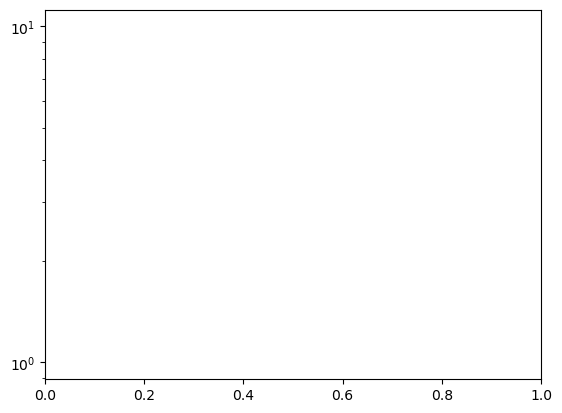

In [129]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")

# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)
ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

# Now work with MSM

In [130]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import mfpt_to_first_last_state

from tistools import create_labels_states

In [131]:
def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [132]:
print(interfaces)
N = len(interfaces)
assert N >= 3
NS = 2*N
print("N", N)
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)
print(labels1, labels2)

[-0.1, 0.0, 0.1, 0.2, 0.3]
N 5
NS 10
['0-     ', 'B      '] ['0+- LML', '0+- LMR', '0+- RML', '1+- LML', '1+- LMR', '1+- RML', '1+- RMR', '2+- LML', '2+- LMR', '2+- RML', '2+- RMR', '3+- LML', '3+- LMR']


In [149]:
def construct_M_istar(P, NS, N):
    """Construct transition matrix M"""
    # N -- number of interfaces
    # NS -- dimension of MSM, 4*N-5 when N>=4
    # P -- ndarray of probabilities for paths between end turns
    
    assert N>=3
    assert N==P.shape[0]
    assert N==P.shape[1]
    assert NS==2*N

    # construct transition matrix
    M = np.zeros((NS,NS))
    
    # states [0-] and [0*+-]
    M[0,2] = 1
    M[2,1] = P[0,0]
    M[2,N+1:] = P[0, 1:]
    M[1,0] = 1
    M[-1,0] = 1
    M[N+1:,1] = P[1:, 0]

    for i in range(1,N):
        #print("starting from state i",i)
        M[2+i, N+i:2*N] = P[i,i:]
        M[N+i, 3:2+i] = P[i, 1:i]
    

    for i in range(NS):
        if np.sum(M[i]) > 0:
            M[i] = M[i]/np.sum(M[i])
        else:
            M[i] = 0
    M[N+1,1] = 1
    # return np.delete(np.delete(M, N, 0), N, 1)
    return M

In [150]:
print("p matrix: ", data["full"])
data["full"][-2][-1] = 0
print("sum rows of p:")
for i in range(data["full"].shape[0]):
    print(np.sum(data["full"][i][:i]), np.sum(data["full"][i][i:]))
M = construct_M_istar(data["full"], NS, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

p matrix:  [[0.43731546 0.02630809 0.12261384 0.01432486 0.39943775]
 [0.         0.         0.26019691 0.02522831 0.71457479]
 [0.96211969 0.03788031 0.         0.03203485 0.96796515]
 [0.69732483 0.0337221  0.26895307 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
sum rows of p:
0.0 1.0
0.0 1.0
1.0 1.0
1.0 0.0
0.0 0.0


In [151]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (10, 10)
sum prob in rows [1.         1.         1.         1.         1.         0.
 0.         1.03788031 1.         1.        ]
[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.43731546 0.         0.         0.         0.
  0.02630809 0.12261384 0.01432486 0.39943775]
 [0.         0.         0.         0.         0.         0.
  0.         0.26019691 0.02522831 0.71457479]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.03203485 0.96796515]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.03788031 0.         0.
  0.         0.         0.         0.        ]
 [0. 

# Look at this Markov model

In [136]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 9.91578237e-01+0.j         -4.19568957e-01+0.81879862j
 -4.19568957e-01-0.81879862j -1.60530255e-01+0.j
 -1.04461485e-01+0.j          8.06537663e-02+0.j
  3.18976504e-02+0.j         -1.28436222e-17+0.j
  0.00000000e+00+0.j        ]
[ 0.00000000e+00+0.j          9.91578237e-01+0.j
 -4.19568957e-01+0.81879862j -4.19568957e-01-0.81879862j
 -1.60530255e-01+0.j         -1.04461485e-01+0.j
  8.06537663e-02+0.j          3.18976504e-02+0.j
  3.21725116e-17+0.j        ]


In [137]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.         0.43731546 0.         0.         0.         0.02630809
 0.12261384 0.01432486 0.39943775]
1.0
[0.83675321 0.12795827 0.         0.00512772 0.00385271 0.
 0.         0.         0.        ]
0.973691910728061
[1.27958270e-01 0.00000000e+00 8.36753211e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.33421562e-03 2.52784718e-04
 7.39342911e-03]
0.973691910728061
[7.39342911e-03 3.67385062e-01 1.27958270e-01 5.90649382e-05
 6.79872256e-05 2.20133782e-02 1.02597527e-01 1.19863702e-02
 3.34230822e-01]
0.973691910728061
[0.70161588 0.16302762 0.00739343 0.00429063 0.00322377 0.00336634
 0.01570482 0.00183665 0.05121938]
0.9516785325588993
[2.14247003e-01 1.96239240e-02 7.01615884e-01 6.56839422e-04
 4.93973195e-04 1.94506993e-04 2.02294596e-03 3.17428240e-04
 9.13969026e-03]
0.9483121949567359
[2.87636143e-02 3.08995138e-01 2.14247003e-01 8.73341752e-05
 8.53732993e-05 1.84581733e-02 8.61987273e-02 1.00829426e-02
 2.81199382e-01]
0.94811768796375
[

# Pcross with MSM

In [138]:
def global_cross_prob_star(M, doprint=False):
    # probability to arrive in -1 before 0
    # given that you are at 0 now and that you are leaving 0
    # = crossing probability from 0 to -1

    NS = len(M)
    assert NS>2

    # take pieces of transition matrix
    Mp = M[2:-1,2:-1]
    a = np.identity(NS-3)-Mp    # 1-Mp
    # a1 = np.linalg.inv(a)       # (1-Mp)^(-1)  --> bad practice!

    # other pieces
    D = M[2:-1, np.array([0,-1])]
    E = M[np.array([0,-1]), 2:-1]
    M11 = M[np.array([0,-1]),np.array([0,-1])]

    # compute Z vector
    z1 = np.array([[0],[1]])
    # z2 = np.dot(a1,np.dot(D,z1))
    z2 = np.linalg.solve(a, np.dot(D,z1))

    # compute H vector
    y1 = np.dot(M11,z1) + np.dot(E,z2)
    y2 = np.dot(D,z1) + np.dot(Mp,z2)

    if doprint:
        print("Mp eigenvals")
        vals, vecs = np.linalg.eig(Mp)
        print(vals)
        print("1-Mp eigenvals")
        vals, vecs = np.linalg.eig(a)
        print(vals)
        #print(np.dot(a,a1)  # identity matrix indeed
        print("other pieces M")
        print(D)
        print(E)
        print(M11)
        print("vector z1,z2")
        print(z1)
        print(z2)
        print("vector y1,y2")
        print(y1)
        print(y2)
        print("check", np.sum((y2-z2)**2))  # 0, so z2 and y2 indeed the same
    return z1, z2, y1, y2

In [139]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob_star(M, True)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Mp eigenvals
[ 0.         -0.11208822 -0.08221433  0.11208822  0.08221433  0.        ]
1-Mp eigenvals
[1.         0.88791178 0.91778567 1.11208822 1.08221433 1.        ]
other pieces M
[[0.         0.39943775]
 [0.         0.71457479]
 [0.         0.96796515]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[0. 0.]
vector z1,z2
[[0]
 [1]]
[[ 0.40694068]
 [ 0.72901071]
 [ 0.97717187]
 [-0.        ]
 [ 0.02761515]
 [ 0.28739714]]
vector y1,y2
[[0.40694068]
 [0.        ]]
[[0.40694068]
 [0.72901071]
 [0.97717187]
 [0.        ]
 [0.02761515]
 [0.28739714]]
check 3.0935249731719976e-33
Z
state 0-      0
state B       1
state 0+- LML 0.40694067645189275
state 0+- LMR 0.7290107075334438
state 0+- RML 0.9771718716251482
state 1+- LML -0.0
state 1+- LMR 0.02761515474839559
state 1+- RML 0.28739714465062405
Y
state 0-      0.40694067645189275
state B       0.0
state 0+- LML 0.40694067645189275
state 0+- LMR 0.7290107075334438


# Collecting times

In [125]:
#TODO I need data too?

In [57]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [58]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [59]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name[-3:]}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [109]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

Collect tau
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/004
ensemble 5 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/005
ensemble 6 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/006
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/001
Collect tau1
Collect tau2
Collect taum


In [110]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

tau
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0         122.6
1 001           41.0         132.9         129.9           0.0
2 002          558.3         690.8         697.8         849.9
3 003          857.0         578.4         574.5         468.0
4 004          220.2         169.6         170.6         196.5
5 005          174.1         139.2         137.9         163.1
6 006          144.0         114.5         112.1         141.0

tau1
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0           0.0
1 001            0.0           0.0         129.9           0.0
2 002          135.1         133.9         330.5         305.8
3 003          338.2         321.8          54.6          55.0
4 004           54.1          53.4          55.7          54.6
5 005           55.7          54.7          41.4          42.9
6 006           43.1          41.4          3

In [111]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [112]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[122.59844936  40.95532539 132.88517875 129.89168347 558.25282787
 690.82414272 697.81777379 849.92352941 856.95789217 578.36564823
 574.48554716 467.97282638 220.24115756 169.63737921 170.64555582
 196.52998436 174.06787707 139.15997954 137.86758565 163.07190705
 143.97923281 114.52065576   0.        ]


tau1
[  0.           0.           0.         129.89168347 135.14434756
 133.93721038 330.54241472 305.82352941 338.18297432 321.83558936
  54.5684215   55.03888919  54.0726072   53.40919161  55.68400095
  54.62489136  55.68876489  54.74841044  41.44391884  42.92442956
  43.0765107   41.36328045   0.        ]
taum
[122.59844936  40.95532539   0.           0.         288.43468998
 226.48540315 229.43087971 234.05882353 185.48679567 201.91053242
 197.16673071 358.40817378 111.97281322  61.35465473  61.10836691
  86.63045368  63.11268427  42.23540159  41.92135703  76.86215198
  57.6097434   38.96362302   0.        ]
tau2
[  0.           0.         132.88517875   0.         134.6737903

# Compute tau for [0+]

In [113]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 40.95532539064838
state 0+- LMR 634.4580991219331
state 0+- RML 0.0
state 1+- LML 423.1084803092534
state 1+- LMR 2156.9980787004515
state 1+- RML 367.2753590664273
state 1+- RMR 2144.211146355688
state 2+- LML 951.3505544465012
state 2+- LMR 2058.2664283562713
state 2+- RML 952.4927622497322
state 2+- RMR 2214.670306676231
state 3+- LML 1890.558398157917
state 3+- LMR 1584.2888227866179
state 3+- RML 1839.3514026696503
state 3+- RMR 1609.9657281784657
state 4+- LML 1908.5776623010288
state 4+- LMR 888.2220093777526
state 4+- RML 1886.622216918643
state 4+- RMR 923.9579177737457
state 5+- LML 1736.3219588347583
state 5+- LMR 73.15737531095795
H
state 0-      93.1689994269615
state B       0.0
state 0+- LML 0.0
state 0+- LMR 634.4580991219332
state 0+- RML 0.0
state 1+- LML 134.6737903314371
state 1+- LMR 1930.5126755493857
state 1+- RML 137.84447935368044
state 1+- RMR 1910.1523228262758
state 2+- LML 765.8637587789826
state 2+- LMR 1

In [114]:
print(h1[0])

[93.16899943]


# Flux

In [115]:
flux = 1/(tau[0]+h1[0])
# dt = 0.0002
# dt = 0.00002
dt = 0.01
flux
print(flux/dt, "1/time")

[0.46346194] 1/time
